# Exploring CMH Parking Violations

## Imports

* pandas
* string
    * parse string amounts to translate into floats

In [2]:
#%matplotlib inline

import datetime
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

## Loading data

### Violations

[Columbus City Parking Violations and Ticket Status 2013-2018 -- COLUEXTRACT](https://discovery.smartcolumbusos.com/dataset/conduent/160c98a1_ad56_4658_8553_5ee8e7d0d953) - Smart Columbus

This dataset covers the parking violations identified by Parking Enforcement Officer (PEO) and the tickets issued for those violations. Also, the data identifies the status of the ticket (e.g., paid, dismissed, etc.,) This dataset covers years 2013 through 2018.

In [3]:
violations_full = pd.read_csv("../data/raw/160c98a1-ad56-4658-8553-5ee8e7d0d953.csv.gz", compression = 'gzip', low_memory = False)

### Meters


Meters is a dataset that contains the location of every meter in Columbus.  The Violations
dataset reports the meter where a violation was issued, but the location is often missing, and even when it's there it's location doesn't precisely match that of the meter for which the
violation was issued.  I suspect this is because the location is based on where the the
Agent (or their hand-held device) when the data was transmitted.

Thankfully the meter number is present in the Violations dataset, so we can join the Violations and Meters dataset to get the location of the meter for which a violation was issued.

In [4]:
meters = pd.read_csv("../data/raw/d9b11b8f-67f3-48c4-8831-0f22d93166ce")

In [5]:
pd.set_option('display.max_columns', None)
# uncomment to see all the fields and their types:
#violations_full.info()

### Dictionary for parking violations
An explanation of all the fields in the violations dataset


In [6]:
violations_dictionary = pd.read_json("https://data.smartcolumbusos.com/api/v1/dataset/160c98a1-ad56-4658-8553-5ee8e7d0d953/dictionary")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)
violations_dictionary.head(98)

,type,name,description
0,integer,ENTITY,Unique system-generated number to identify license plate-based accounts
1,integer,TERMDT,"If a license plate was on a fleet and terminated, this would record the date on which the plate was terminated from the fleet. Julian date format."
2,integer,MULTNO,"If a license plate was on a fleet, that fleet is identified with this number"
3,string,ENT DUE,Total amount due on the entity
4,string,ENT OVP,Overpaid amount on the entity
5,integer,CONF DT,Date on which the BMV/Registry returned registered owner name and address information
6,integer,HOLD CT,Total number of tickets on the entity on registration hold
7,integer,LAST SEIZ,Date on which the vehicle was last seized
8,string,SEIZ STAT,Indicates if the vehicle is currently seized
9,integer,SEIZ DT,Date on which the vehicle was released on the last seizure record


In [7]:
# work with the most promissing columns:
violations = violations_full[['ticket', 'entity', 'meter', 'iss dt', 'multno', 'hold ct', 'due', 'fine', 'make', 'iss time', 'time2', 'ticket', 'badge', 'pay amt', 'pay meth', 'plea', 'open ct', 'lat', 'long']].copy()
violations['issue_date'] = violations['iss dt'].map(lambda dtStr: datetime.datetime.strptime(str(dtStr), '%Y%j'))
violations['year'] = violations['issue_date'].map(lambda dt: dt.year)
violations['dayOfWeek'] = violations['issue_date'].map(lambda dt: dt.weekday())
violations['hour'] = violations['iss time'] / 100

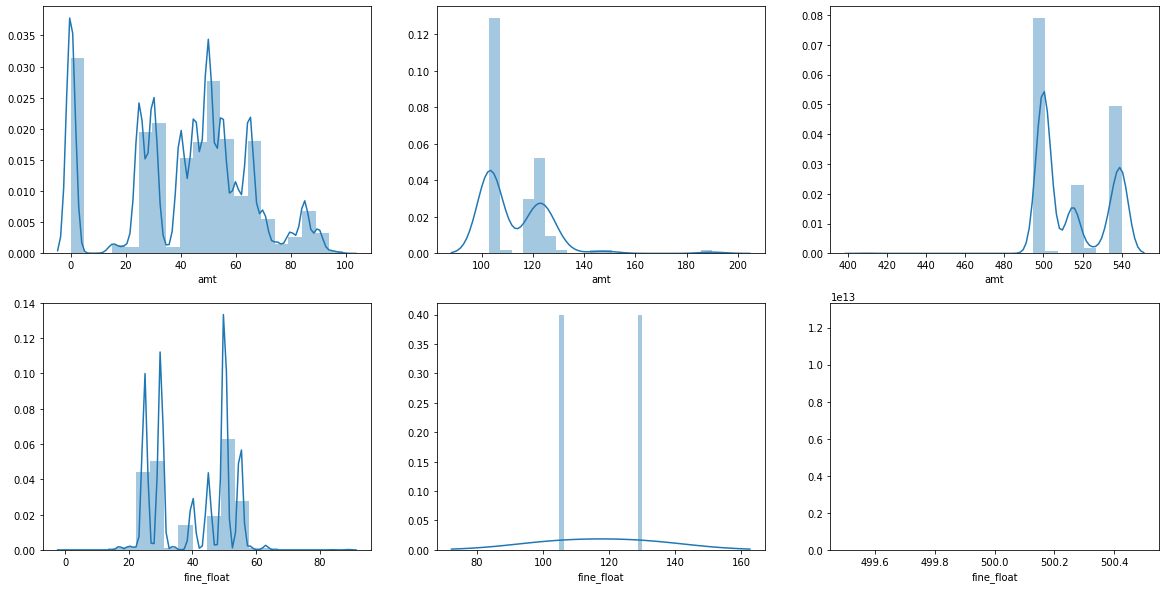

In [8]:
# convert 'pay amt' into a float
import string
trans_dict ={ord('$'): None, ord('('): None, ord(')'): None, ord(","): None} 
violations['amt'] = violations['pay amt'].str.translate(trans_dict).astype(float)
violations['fine_float'] = violations['fine'].str.translate(trans_dict).astype(float)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=False, figsize=(20,10))

# after removing outliers (amounts > 100), here's the distribution of fines:
sns.distplot(violations[violations['amt'] < 100]['amt'], bins = 20, ax=ax1)
sns.distplot(violations[(violations['amt'] > 100) & (violations['amt'] < 200)]['amt'], bins = 20, ax=ax2)
sns.distplot(violations[(violations['amt'] > 400) & (violations['amt'] < 600)]['amt'], bins = 20, ax=ax3)
sns.distplot(violations[violations['fine_float'] < 100]['fine_float'], bins = 20, ax=ax4)
sns.distplot(violations[(violations['fine_float'] > 100) & (violations['fine_float'] < 200)]['fine_float'], bins = 20, ax=ax5)
sns.distplot(violations[(violations['fine_float'] > 400) & (violations['fine_float'] < 600)]['fine_float'], bins = 20, ax=ax6)
# also this weird fine:
#violations[violations['amt'] > 900]

In [9]:
violations.info()
violations.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 25 columns):
ticket        745821 non-null object
entity        745821 non-null int64
meter         418804 non-null object
iss dt        745821 non-null int64
multno        745821 non-null int64
hold ct       745821 non-null int64
due           745821 non-null object
fine          745821 non-null object
make          744965 non-null object
iss time      745821 non-null int64
time2         745821 non-null int64
ticket        745821 non-null object
badge         733375 non-null object
pay amt       745821 non-null object
pay meth      745821 non-null int64
plea          0 non-null float64
open ct       745821 non-null int64
lat           745821 non-null int64
long          745821 non-null int64
issue_date    745821 non-null datetime64[ns]
year          745821 non-null int64
dayOfWeek     745821 non-null int64
hour          745821 non-null float64
amt           745821 non-null float64
fine_fl

,ticket,entity,meter,iss dt,multno,hold ct,due,fine,make,iss time,time2,ticket,badge,pay amt,pay meth,plea,open ct,lat,long,issue_date,year,dayOfWeek,hour,amt,fine_float
306110,5561842616,3313348,NaN,2013173,0,0,$0.00,$40.00,JEEP,953,0,5561842616,10,$40.00,1,NaN,0,0,0,2013-06-22,2013,5,9.53,40.0,40.0
234138,5563353496,3406500,SK101,2014212,0,0,$0.00,$25.00,CHEV,1132,0,5563353496,9,$40.00,4,NaN,0,0,0,2014-07-31,2014,3,11.32,40.0,25.0
223645,5564118342,3444097,EA17,2014364,0,0,$0.00,$25.00,CADI,1314,0,5564118342,16,$40.00,4,NaN,0,0,0,2014-12-30,2014,1,13.14,40.0,25.0
174175,5563885872,3260105,NS256,2014337,0,0,$0.00,$25.00,CHEV,1352,0,5563885872,16,$25.00,2,NaN,0,0,0,2014-12-03,2014,2,13.52,25.0,25.0
610913,5567496225,3646157,SJ1,2017229,0,1,$65.00,$30.00,KIA,1221,0,5567496225,8,$0.00,0,NaN,1,0,0,2017-08-17,2017,3,12.21,0.0,30.0
17287,5566133955,3479556,SO454,2016163,0,0,$0.00,$30.00,MAZD,1811,0,5566133955,13,$45.00,4,NaN,0,0,0,2016-06-11,2016,5,18.11,45.0,30.0
31122,5565225554,3503637,K765,2015274,0,0,$0.00,$30.00,CHRY,1053,0,5565225554,12,$65.00,4,NaN,0,0,0,2015-10-01,2015,3,10.53,65.0,30.0
657898,5564208104,3377515,V36,2015009,0,0,$0.00,$50.00,CHEV,1006,0,5564208104,12,$90.00,4,NaN,0,0,0,2015-01-09,2015,4,10.06,90.0,50.0
584321,5566359451,3580386,SM408,2016267,0,0,$0.00,$30.00,PONT,2030,0,5566359451,5,$45.00,4,NaN,0,0,0,2016-09-23,2016,4,20.30,45.0,30.0
405306,5566834434,3600452,NaN,2016358,0,0,$0.00,$50.00,LEXU,1925,0,5566834434,13,$50.00,4,NaN,0,0,0,2016-12-23,2016,4,19.25,50.0,50.0


In [10]:
# wonder why number of violations issued went down over the years?
violations['year'].value_counts()

2014    158001
2013    157787
2015    141000
2016    137000
2017    119000
2018    33033 
Name: year, dtype: int64

          amt        
        count     sum
entity               
3306104  171   5965.0
3172961  149   6110.0
3118181  141   5990.0
2954098  107   3530.0
3177010  100   3315.0
3310867  96    4427.0
3190248  93    3515.0
3369215  88    3775.0
3373505  83    3625.0
3577369  82    3195.0
3044891  82    3095.0
3474796  81    3060.0
3307004  81    3815.0
3020192  79    2845.0
3341297  77    3405.0
3244622  77    3305.0
3132197  75    3230.0
2857433  74    2675.0
3223602  73    2755.0
2900185  71    2920.0
3258227  70    2840.0
2985345  70    2160.0
2904972  68    2250.0
3276147  68    3840.0
3257274  66    2258.0


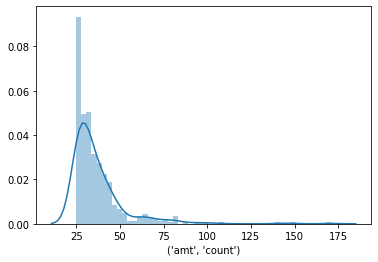

In [11]:
# distribution of outliers - entities who got more than 25 tickets
entity_tickets = violations[['entity', 'amt']].groupby('entity').agg(['count', 'sum']).sort_values([('amt', 'count')], ascending=False)
print(entity_tickets.head(25))

sns.distplot(entity_tickets[('amt', 'count')]\
             [(entity_tickets[('amt', 'count')] >= 25)], bins = 50)

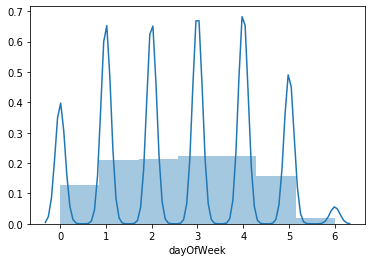

In [12]:
sns.distplot(violations['dayOfWeek'], bins = 7)

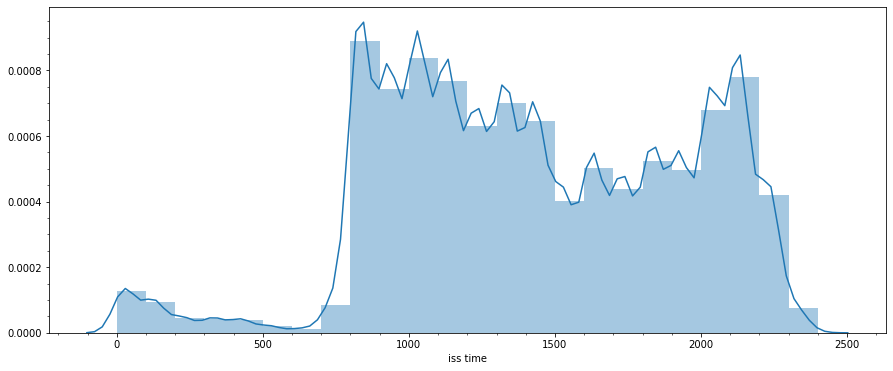

In [13]:
plt.figure(figsize=(15, 6))
ax = sns.distplot(violations['iss time'], bins = 24, norm_hist=True,)
ax.minorticks_on()

#### All about agents (as identified by badge)

In [14]:
print(violations[['badge']].describe())
agent_business = violations[['badge','year', 'entity', 'ticket', 'amt']]\
    .groupby(['badge', 'year'])\
        .agg({'amt': ['mean', 'min', 'max'], 'entity': ['count']})

agent_business.columns = ['amt_mean', 'amt_min', 'amt_max', 'entity_count']
agent_business.reset_index().sort_values('entity_count', ascending=False).head(25)

         badge
count   733375
unique  2051  
top     13    
freq    73110 


,badge,year,amt_mean,amt_min,amt_max,entity_count
1848,19,2013,41.011145,0.0,540.0,24003
408,13,2015,46.363790,0.0,540.0,18202
1849,19,2014,40.199812,0.0,540.0,18127
2026,20,2015,47.857323,0.0,540.0,17498
407,13,2014,40.510729,0.0,540.0,16684
409,13,2016,46.612510,0.0,5445.0,16683
2027,20,2016,47.854603,0.0,540.0,15695
410,13,2017,45.479786,0.0,540.0,14693
7,10,2014,46.131300,0.0,540.0,13214
6,10,2013,46.733612,0.0,540.0,12936


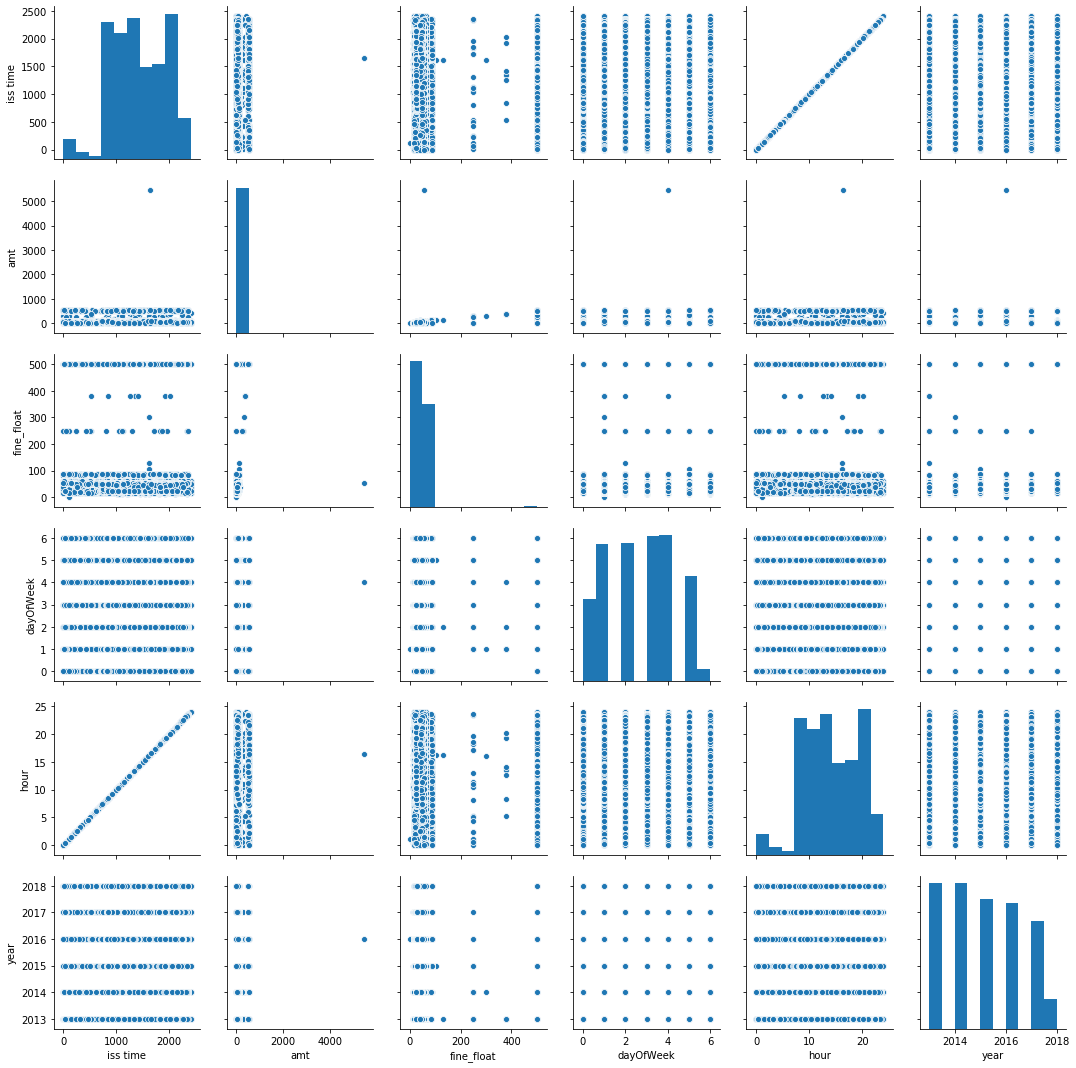

In [15]:
violations_clean = violations[['make', 'iss time', 'badge', 'amt', 'fine_float', 'dayOfWeek', 'hour', 'year']].dropna()
sns.pairplot(violations_clean)

#### How many tickets are generally given each day?

            Meter
issue_date       
2013-01-01  0    
2013-01-02  354  
2013-01-03  384  
2013-01-04  379  
2013-01-05  320  
...         ...  
2018-04-17  276  
2018-04-18  275  
2018-04-19  254  
2018-04-20  257  
2018-04-21  30   

[1937 rows x 1 columns]


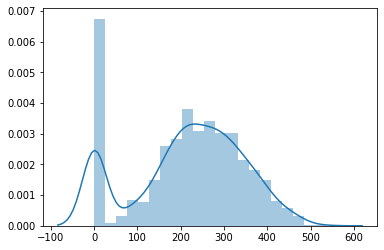

In [54]:
violations_by_day = violations[['issue_date', 'Meter']].groupby(['issue_date']).count()
sns.distplot(violations_by_day)
print(violations_by_day)

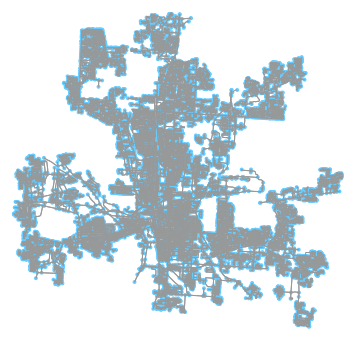

In [18]:
# get network graph for Columbus from disk if available (much faster to load)
try:
    G = ox.load_graphml('cmh_network.graphml')
except IOError:
    print("Download and save network.")
    G = ox.graph_from_place('Columbus, Ohio, USA', network_type='drive')
    ox.save_graphml(G, filename='cmh_network.graphml')
    G = ox.load_graphml('cmh_network.graphml')

fig, ax = ox.plot_graph(G)

In [19]:
# get min, max for lat long as coordinates from G, to get bounds
cmh_gdf = ox.graph_to_gdfs(G)
print(cmh_gdf[0].x.agg(['min', 'max']))
print(cmh_gdf[0].y.agg(['min', 'max']))

cmh_n = float(cmh_gdf[0].y.agg('max'))
cmh_s = float(cmh_gdf[0].y.agg('min'))
cmh_e = float(cmh_gdf[0].x.agg('max'))
cmh_w = float(cmh_gdf[0].x.agg('min'))

print(cmh_n, cmh_s, cmh_e, cmh_w)

min   -83.172436
max   -82.772184
Name: x, dtype: float64
min    39.860829
max    40.152758
Name: y, dtype: float64
40.1527582 39.860829 -82.7721843 -83.172436


In [20]:
# convert lat/long to usable lat/long float values
violations['lat_float'] = violations['lat'] / 1000000
violations['long_float'] = violations['long'] / 1000000 * -1

#### Exploring Meters

In [21]:
# meters

meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone            5490 non-null object
Area            5490 non-null object
Sub Area        5490 non-null object
Meter Number    5490 non-null object
ConfigId        5490 non-null int64
Lat             5490 non-null float64
Long            5490 non-null float64
Active          5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [22]:
#meters[meters['meter number'] == 'EN529']

meters = meters.rename(columns = {'Meter Number': 'Meter'})
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone        5490 non-null object
Area        5490 non-null object
Sub Area    5490 non-null object
Meter       5490 non-null object
ConfigId    5490 non-null int64
Lat         5490 non-null float64
Long        5490 non-null float64
Active      5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


### Merging violations and meters

In [23]:
violations = violations.rename(columns = { 'meter': 'Meter'})
violations.info()
meters_loc = meters[['Meter', 'Lat', 'Long']]

violations_x_meters = violations.merge(meters, how = 'left', on = 'Meter')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 27 columns):
ticket        745821 non-null object
entity        745821 non-null int64
Meter         418804 non-null object
iss dt        745821 non-null int64
multno        745821 non-null int64
hold ct       745821 non-null int64
due           745821 non-null object
fine          745821 non-null object
make          744965 non-null object
iss time      745821 non-null int64
time2         745821 non-null int64
ticket        745821 non-null object
badge         733375 non-null object
pay amt       745821 non-null object
pay meth      745821 non-null int64
plea          0 non-null float64
open ct       745821 non-null int64
lat           745821 non-null int64
long          745821 non-null int64
issue_date    745821 non-null datetime64[ns]
year          745821 non-null int64
dayOfWeek     745821 non-null int64
hour          745821 non-null float64
amt           745821 non-null float64
fine_fl

In [24]:
# TODO: make faster if possible.. vectorization?
fudge = 0.2
violations_x_meters['lat_combined'] = \
    violations_x_meters.apply(lambda p: p['Lat'] if (p['Lat'] >  cmh_s - fudge) & (p['Lat'] < cmh_n + fudge) \
                                    else p['lat_float'], axis=1)
violations_x_meters['long_combined'] = \
    violations_x_meters.apply(lambda p: p['Long'] if (p['Long'] >  cmh_w - fudge) & (p['Long'] < cmh_e + fudge)  \
                                    else  p['long_float'], axis=1)
violations_x_meters.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 745821 entries, 0 to 745820
Data columns (total 36 columns):
ticket           745821 non-null object
entity           745821 non-null int64
Meter            418804 non-null object
iss dt           745821 non-null int64
multno           745821 non-null int64
hold ct          745821 non-null int64
due              745821 non-null object
fine             745821 non-null object
make             744965 non-null object
iss time         745821 non-null int64
time2            745821 non-null int64
ticket           745821 non-null object
badge            733375 non-null object
pay amt          745821 non-null object
pay meth         745821 non-null int64
plea             0 non-null float64
open ct          745821 non-null int64
lat              745821 non-null int64
long             745821 non-null int64
issue_date       745821 non-null datetime64[ns]
year             745821 non-null int64
dayOfWeek        745821 non-null int64
hour             

In [25]:
violations_x_meters.head(12)

,ticket,entity,Meter,iss dt,multno,hold ct,due,fine,make,iss time,time2,ticket,badge,pay amt,pay meth,plea,open ct,lat,long,issue_date,year,dayOfWeek,hour,amt,fine_float,lat_float,long_float,Zone,Area,Sub Area,ConfigId,Lat,Long,Active,lat_combined,long_combined
0,5565039450,3487595,F48,2015205,0,0,$0.00,$30.00,DODG,2035,0,5565039450,17,$30.00,4,NaN,0,0,0,2015-07-24,2015,4,20.35,30.0,30.0,0.0,-0.0,"Columbus, OH Default Zone",Route 26,GREENWOOD LOT,979.0,39.985930,-83.006227,1.0,39.985930,-83.006227
1,5564345326,3453663,NaN,2015044,0,0,$0.00,$55.00,CHEV,1110,0,5564345326,16,$90.00,4,NaN,0,0,0,2015-02-13,2015,4,11.10,90.0,55.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.000000
2,5566101825,3376679,NaN,2016154,0,0,$0.00,$50.00,TOYT,2049,0,5566101825,13,$65.00,4,NaN,0,0,0,2016-06-02,2016,3,20.49,65.0,50.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.000000
3,5564388332,3403466,WN11,2015055,0,0,$0.00,$30.00,HOND,1010,0,5564388332,8,$45.00,4,NaN,0,0,0,2015-02-24,2015,1,10.10,45.0,30.0,0.0,-0.0,"Columbus, OH Default Zone",Route 02,BROAD ST W,987.0,39.962046,-83.001262,1.0,39.962046,-83.001262
4,5565398944,3404432,NaN,2015311,0,0,$0.00,$55.00,MERC,936,0,5565398944,10,$70.00,4,NaN,0,0,0,2015-11-07,2015,5,9.36,70.0,55.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.000000
5,5564552703,3403466,WN106,2015072,0,0,$0.00,$30.00,HOND,1608,0,5564552703,20,$45.00,4,NaN,0,0,0,2015-03-13,2015,4,16.08,45.0,30.0,0.0,-0.0,"Columbus, OH Default Zone",Route 02,BROAD ST W,979.0,39.962079,-83.002973,1.0,39.962079,-83.002973
6,5564385856,3402536,K332,2015050,0,0,$0.00,$30.00,FORD,1427,0,5564385856,9,$30.00,2,NaN,0,0,0,2015-02-19,2015,3,14.27,30.0,30.0,0.0,-0.0,"Columbus, OH Default Zone",Route 16,PARK ST N,979.0,39.975019,-83.004639,1.0,39.975019,-83.004639
7,5594213232,3406864,NaN,2014210,0,0,$15.00,$50.00,HYUN,1640,0,5594213232,1843,$50.00,2,NaN,1,0,0,2014-07-29,2014,1,16.40,50.0,50.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.000000
8,5562730846,3166187,NK265,2014044,0,0,$85.00,$50.00,CHEV,1621,0,5562730846,19,$0.00,0,NaN,2,0,0,2014-02-13,2014,3,16.21,0.0,50.0,0.0,-0.0,"Columbus, OH Default Zone",Route 29,High St N,987.0,39.967934,-83.001909,1.0,39.967934,-83.001909
9,5595457961,3406828,NaN,2014209,0,0,$0.00,$25.00,DODG,1024,0,5595457961,NaN,$25.00,2,NaN,0,0,0,2014-07-28,2014,0,10.24,25.0,25.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.000000


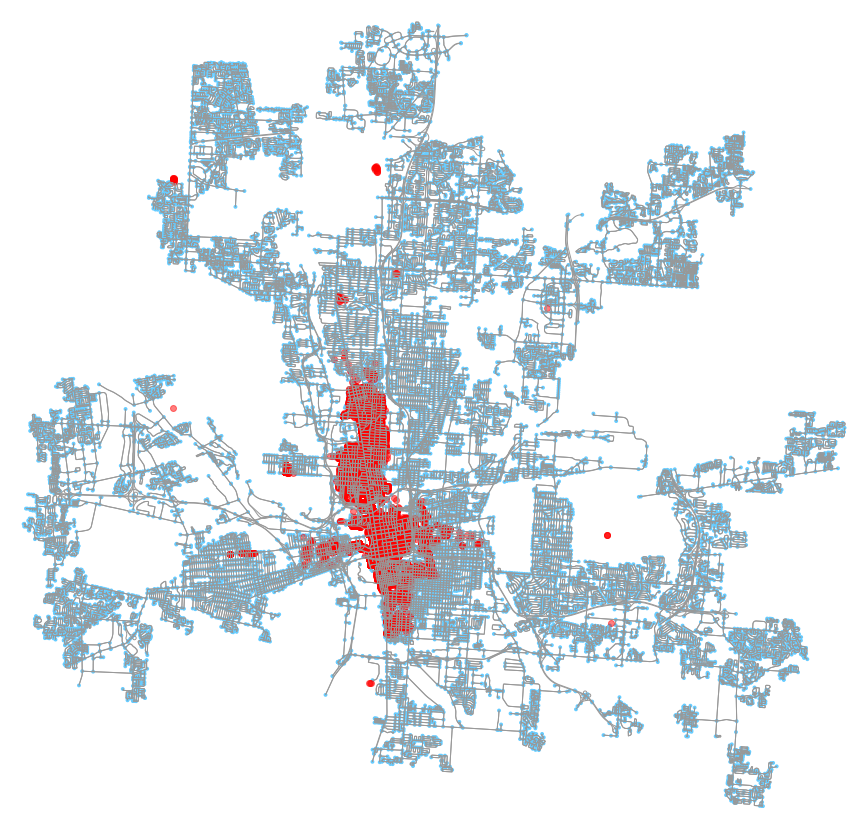

In [26]:
fig, ax = ox.plot_graph(G, fig_height=15, show=False, close=False)
ax.scatter(violations_x_meters['long_combined'], violations_x_meters['lat_combined'], alpha=0.5, c='red')

In [ ]:
# 2013-01-03
violations_for_day = violations_x_meters[violations_x_meters['issue_date'] == '2013-01-03']

bbox = ox.core.bbox_from_point((39.977110, -83.003500), 4000)
north, south, east, west = bbox
G0 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
fig, ax = ox.plot_graph(G0, fig_height=15, show=False, close=False)

import hashlib
def encode_badge(badge):
    encoded_badge = str(badge).encode('utf-8')
    return int(hashlib.sha1(encoded_badge).hexdigest(), 16) % (10 ** 8) % 10000
 
badge_to_colors = violations_for_day['badge'].map(encode_badge)                                    
ax.scatter(violations_for_day['long_combined'], violations_for_day['lat_combined'], \
           alpha=0.5, c=badge_to_colors, marker = 'h')

In [27]:
bbox = ox.core.bbox_from_point((39.977110, -83.003500), 500)
north, south, east, west = bbox
short_north_violations = violations_x_meters[(violations_x_meters['long_combined'] < east) &
                                            (violations_x_meters['long_combined'] > west) &
                                            (violations_x_meters['lat_combined'] < north) &
                                            (violations_x_meters['lat_combined'] > south) &
                                            (violations_x_meters['year'] == 2017)
                                            ]
short_north_violations.shape
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')

In [28]:
short_north_violations.shape

(11924, 36)

In [29]:
early_morning_violations =  short_north_violations[(short_north_violations['iss time'] >= 500) & \
                                                     (short_north_violations['iss time'] < 700)]
morning_violations = short_north_violations[(short_north_violations['iss time'] >= 700) & \
                                                     (short_north_violations['iss time'] < 1000)]
midday_violations =  short_north_violations[(short_north_violations['iss time'] >= 1000) & \
                                                     (short_north_violations['iss time'] < 1400)]
afternoon_violations = short_north_violations[(short_north_violations['iss time'] >= 1400) & \
                                                     (short_north_violations['iss time'] < 1800)]
evening_violations =  short_north_violations[(short_north_violations['iss time'] >= 1800) & \
                                                     (short_north_violations['iss time'] < 2200)]
night_violations =  short_north_violations[(short_north_violations['iss time'] >= 2300) & \
                                                     (short_north_violations['iss time'] < 500)]

#### Create bounding box 1 mile around the Forge, and plot violations around this area

In [30]:
#bbox = ox.core.bbox_from_point((39.977110, -83.003500), 1609.34)
#fig, ax = ox.plot_graph(G, bbox, fig_height=15,fig_width=15,  show=False, close=False, annotate=False)
#ax.scatter(violations_x_meters['long_combined'], violations_x_meters['lat_combined'], alpha=0.4, c='red')

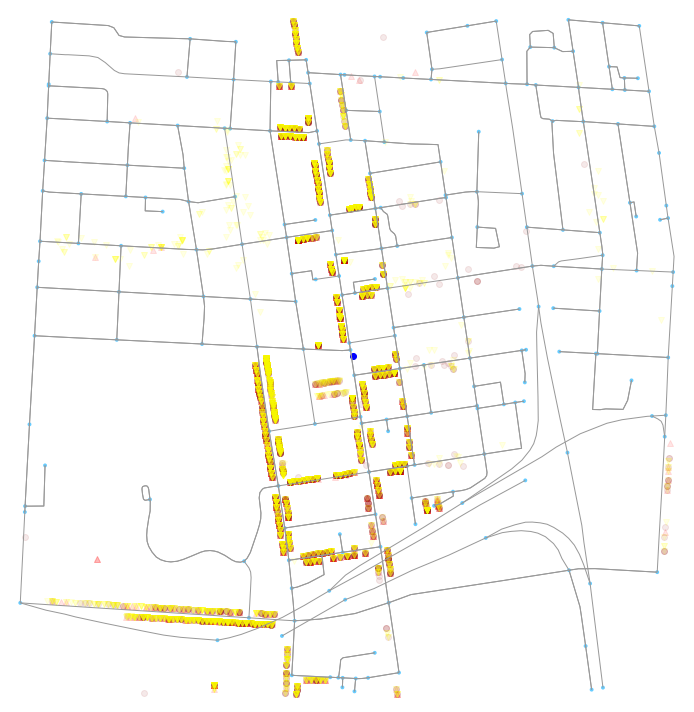

In [31]:
fig, ax = ox.plot_graph(G1, fig_height=10,show=False, close=False)
#ax.scatter(violations_x_meters['long_combined'], violations_x_meters['lat_combined'], alpha=0.2, c='red')

#ax.scatter(midday_violations['long_combined'], midday_violations['lat_combined'], alpha=0.1, c='green', marker="o")
ax.scatter(morning_violations['long_combined'], morning_violations['lat_combined'], alpha=0.1, c='red',marker="^")
ax.scatter(afternoon_violations['long_combined'], afternoon_violations['lat_combined'], alpha=0.1, c='brown')
ax.scatter(evening_violations['long_combined'], evening_violations['lat_combined'], alpha=0.1, c='yellow',marker="v")
#ax.scatter(night_violations['long_combined'], night_violations['lat_combined'], alpha=0.4, c='gray')

ax.scatter([-83.003500], [39.977110], c='blue')
plt.tight_layout()


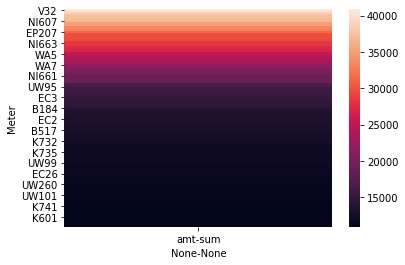

In [32]:
grp = violations_x_meters[['Meter', 'amt']].dropna()\
    .groupby(['Meter'], as_index=False)\
    .agg(['sum'])\
    .sort_values([('amt', 'sum')], ascending=False)\
    .head(100)
sns.heatmap(grp)


In [33]:
grp.loc['NI659'][('amt', 'sum')]


20415.0

In [34]:
hot_meter_numbers = pd.Series(grp.index)
hot_meters = short_north_violations[violations_x_meters['Meter'].isin(hot_meter_numbers)]
hot_meters.shape

/Users/ovidiu.sofariu/Library/Caches/pypoetry/virtualenvs/cmh-packing-violations-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(1786, 36)

In [35]:
# plot the route with folium
route_map = ox.plot_graph_folium(G1, popup_attribute='name', edge_width=2)

import folium
folium.Marker(
    location=[39.977110, -83.003500],
    popup='The Forge',
    icon=folium.Icon(icon='glyphicon-scale', prefix='glyphicon')
).add_to(route_map)


# morning_violations.apply(lambda row: \
#               folium.Marker(
#                 location=[row['lat_combined'], row['long_combined']],
#                 popup=row.Meter,
#                 icon=folium.Icon(icon='dollar-sign', prefix='fa')
#              ).add_to(route_map),
#              axis=1)

hot_meters.apply(lambda row: \
              folium.Marker(
                location=[row['lat_combined'], row['long_combined']],
                popup=grp.loc[row['Meter']][('amt', 'sum')],
                icon=folium.Icon(icon='scale', color='darkgreen')
             ).add_to(route_map),
             axis=1)

# save to disk
filepath = 'data/graph.html'
route_map.save(filepath)

In [36]:
from IPython.display import IFrame
IFrame(filepath, width=600, height=700)

In [37]:
help(folium.Icon)

Help on class Icon in module folium.map:

class Icon(branca.element.MacroElement)
 |  Icon(color='blue', icon_color='white', icon='info-sign', angle=0, prefix='glyphicon', **kwargs)
 |  
 |  Creates an Icon object that will be rendered
 |  using Leaflet.awesome-markers.
 |  
 |  Parameters
 |  ----------
 |  color : str, default 'blue'
 |      The color of the marker. You can use:
 |  
 |          ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
 |           'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
 |           'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
 |           'gray', 'black', 'lightgray']
 |  
 |  icon_color : str, default 'white'
 |      The color of the drawing on the marker. You can use colors above,
 |      or an html color code.
 |  icon : str, default 'info-sign'
 |      The name of the marker sign.
 |      See Font-Awesome website to choose yours.
 |      Warning : depending on the icon you choose you may need to adapt
 |      the `